# Multiclass classification

The multiclass classification problem is a regression problem from an input $x \in {\cal X}$ to discrete labels $y\in {\cal Y}$, where ${\cal Y}$ is a discrete set of size $C$ bigger than two (for $C=2$ it is the more usual binary classification).

Labels are encoded in a one-hot fashion, that is if $C=4$ and $y=2$, we note $\bar{y} = [0,1,0,0]$.

The generative model for this problem consists of: 
 * $C$ latent functions $\mathbf{f} = [f_1,...,f_C]$ with an independent Gaussian Process prior
 * a deterministic function that builds a discrete distribution $\pi(\mathbf{f}) = [\pi_1(f_1),...,\pi_C(f_C)]$ from the latents such that $\sum_c \pi_c(f_c) = 1$ 
 * a discrete likelihood $p(y|\mathbf{f}) = Discrete(y;\pi(\mathbf{f})) = \prod_c \pi_c(f_c)^{\bar{y}_c}$

A typical example of $\pi$ is the softmax function: 

$$ \pi_c (f_c) \propto \exp( f_c)$$

Another convenient one is the robust max:
$$
\pi_c(\mathbf{f}) = \begin{cases} 1 - \epsilon, & \mbox{if } c = \arg \max_c f_c \\
 \epsilon /(C-1), & \mbox{ otherwise} \end{cases}
$$





In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

from gpflow.test_util import notebook_niter
from multiclass_classification import plot_posterior_predictions, colors

np.random.seed(0)

## Sampling from the GP multiclass generative model

### Declaring model parameters and input

In [2]:
# Number of functions and number of data points
C = 3
N = 100

# RBF kernel lengthscale
lengthscale = 0.1

# Jitter
jitter_eye = np.eye(N) * 1e-6

# Input
X = np.random.rand(N, 1)

### Sampling

In [3]:
# RBF kernel matrix
kern = gpflow.kernels.RBF(1, lengthscales=lengthscale)
K = kern.compute_K_symm(X) + jitter_eye

# Latents prior sample
f = np.random.multivariate_normal(mean=np.zeros(N), cov=K, size=(C)).T

# Hard max observation
Y = np.argmax(f, 1).reshape(-1,).astype(int)

# One-hot encoding
Y_hot = np.zeros((N, C), dtype=bool)
Y_hot[np.arange(N), Y] = 1

### Plotting

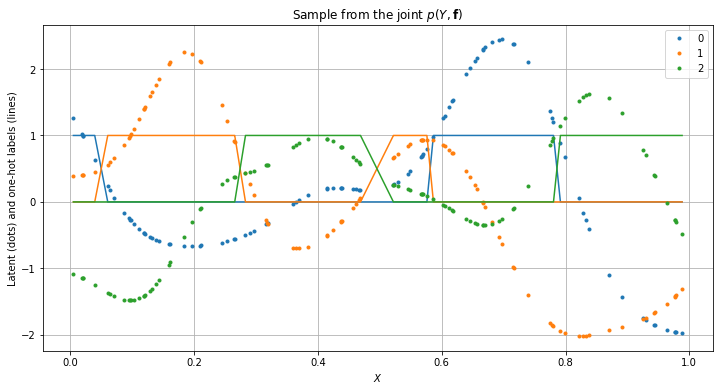

In [4]:
plt.figure(figsize=(12, 6))
order = np.argsort(X.reshape(-1,))

for c in range(C):  
    plt.plot(X[order], f[order, c], '.', color=colors[c], label=str(c))
    plt.plot(X[order], Y_hot[order, c], '-', color=colors[c])


plt.legend()
plt.xlabel('$X$')
plt.ylabel('Latent (dots) and one-hot labels (lines)')
plt.title('Sample from the joint $p(Y, \mathbf{f})$')
plt.grid()
plt.show()

## Inference


Inference here consists of computing the posterior distribution over the latent functions given the data $p(\mathbf{f}|Y, X)$.

You can use different inference methods. Here we perform variational inference.
For a treatment of the multiclass classification problem using MCMC sampling, see [Markov Chain Monte Carlo (MCMC)](../advanced/mcmc.ipynb).



### Approximate inference: Sparse Variational Gaussian Process

#### Declaring the SVGP model (see [GPs for big data](../advanced/gps_for_big_data.ipynb))

In [5]:
# sum kernel: Matern32 + White
kern = gpflow.kernels.Matern32(1) + gpflow.kernels.White(1, variance=0.01)

# Robustmax Multiclass Likelihood
invlink = gpflow.likelihoods.RobustMax(C)  # Robustmax inverse link function
likelihood = gpflow.likelihoods.MultiClass(3, invlink=invlink)  # Multiclass likelihood
Z = X[::5].copy()  # inducing inputs

m = gpflow.models.SVGP(
    X, Y, kern=kern, likelihood=likelihood,
    Z=Z, num_latent=C, whiten=True, q_diag=True)

# Only train the variational parameters
m.kern.kernels[1].variance.trainable = False
m.feature.trainable = False
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/feature/Z,Parameter,None,(none),False,"(20, 1)",True,"[[0.5488135039273248], [0.6458941130666561], [..."
SVGP/kern/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,1.0
SVGP/kern/kernels/0/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/kern/kernels/1/variance,Parameter,None,+ve,False,(),True,0.01
SVGP/likelihood/invlink/epsilon,Parameter,"Beta(0.2,5.0)","[0.0, 1.0]",False,(),True,0.001
SVGP/q_mu,Parameter,None,(none),True,"(20, 3)",True,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ..."
SVGP/q_sqrt,Parameter,None,+ve,True,"(20, 3)",True,"[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, ..."


#### Running inference

In [6]:
opt = gpflow.train.ScipyOptimizer(options={'maxls': 30,'ftol':1e-10, 'disp':False})
#for _ in range(2):
opt.minimize(m, maxiter=notebook_niter(1000))

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 61.366270
  Number of iterations: 610
  Number of functions evaluations: 687


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 61.366270
  Number of iterations: 610
  Number of functions evaluations: 687


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 61.366270
  Number of iterations: 1
  Number of functions evaluations: 3


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 61.366270
  Number of iterations: 1
  Number of functions evaluations: 3


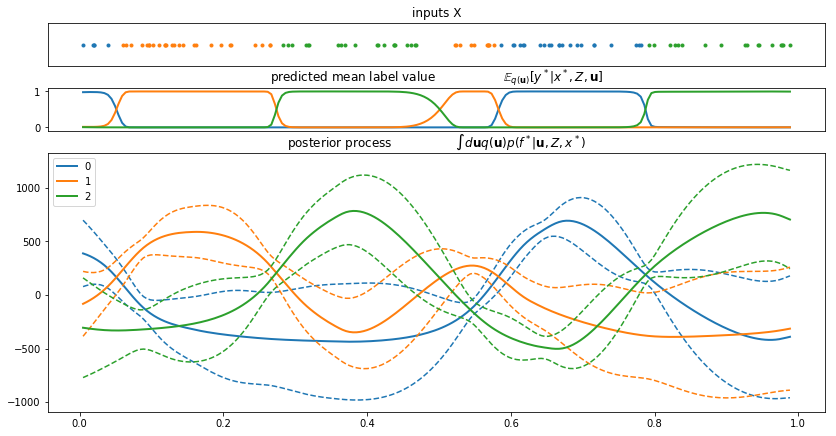

In [7]:
plot_posterior_predictions(m)